In [28]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, brier_score_loss, mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from sklearn.calibration import CalibrationDisplay
import numpy as np
import matplotlib.pyplot as plt
from xgboost import plot_importance

In [29]:
YEARS = [2018, 2019, 2020, 2021, 2022, 2023,2024]

# %%
data_all = pd.DataFrame()

def calculate_seconds(row):
    if row['qtr'] != 5:
        return 3600 - row['game_seconds_remaining']
    else:
        return 600 - row['game_seconds_remaining'] + 3600


def get_quarter_value(dataf):
    if 'END QUARTER' in dataf['desc']:
        return dataf['level_0']
    else:
        return None

for i in YEARS:  
    i_data = pd.read_csv('https://github.com/nflverse/nflverse-data/releases/download/pbp/' \
                   'play_by_play_' + str(i) + '.csv.gz',
                   compression= 'gzip', low_memory= False)

    data_all = pd.concat([data_all,i_data])

ppr = 1

data = data_all.loc[data_all.season_type=='REG']
#data = data_all.loc[(data_all.play_type.isin(['no_play','pass','run'])) & (data_all.epa.isna()==False)]
#data.loc[data['pass']==1, 'play_type'] = 'pass'
#data.loc[data.rush==1, 'play_type'] = 'run'
data.reset_index(drop=True, inplace=True)
data['turnover'] = data['interception'] + data['fumble_lost']
data = data.dropna(subset=['posteam'])
data['inside_10'] = (data['yardline_100'] < 10).astype(int)
data['20+_play'] = (data['yards_gained'] > 19).astype(int)
data['short_pass'] = (data['air_yards'] < 10).astype(int)
data['medium_pass'] = ((data['air_yards'] > 9)&(data['air_yards']<20)).astype(int)
data['deep_pass'] = (data['air_yards'] > 19).astype(int)
data['end_zone_target'] = (data['yardline_100'] - data['air_yards']) <= 0
data['fantasy_points'] = (
    data['complete_pass'] * ppr +          # 1 point per completion
    data['touchdown'] * 6 +           # 6 points per touchdown
    data['yards_gained'] * 0.1        # 0.1 points per yard gained
)
data['distance_to_EZ_after_target'] = data['yardline_100'] - data['air_yards']


C:\Users\src15\AppData\Local\Temp\ipykernel_22164\2001587006.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['turnover'] = data['interception'] + data['fumble_lost']
C:\Users\src15\AppData\Local\Temp\ipykernel_22164\2001587006.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['turnover'] = data['interception'] + data['fumble_lost']
C:\Users\src15\AppData\Local\Temp\ipykernel_22164\2001587006.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.inser

In [30]:
def total_finder(home_or_away,home_total,away_total):
    if home_or_away == 'home':
        total = home_total
    else:
        total = away_total 
    return total

In [31]:
data.reset_index(drop=True, inplace=True)

data = data[data['two_point_attempt']==0]


 # derive implied team total from betting market data
data['home_implied_total'] = abs(data['total_line'] / 2 + data['spread_line'] / 2)
data['away_implied_total'] = abs(data['total_line'] / 2 - data['spread_line'] / 2)

    # Use list comprehension with zip for more efficient row-wise operations
data['implied_posteam_total'] = [
    total_finder(has_ball, home_number, away_number)
        for has_ball, home_number, away_number in zip(data['posteam_type'], data['home_implied_total'], data['away_implied_total'])
]

    

        
    # we only want throws aka plays with air yardage (no running plays, sacks, throwaways etc.)
throws = data[data['air_yards'].notna()]
    # only data before the current szn
#throws = throws[throws['season']!=2024]
#throws = throws[throws['receiver_player_name'].notna()]
throws = throws[throws['pass_location'].notna()]

    
df = throws[['receiver_player_name','receiver_player_id','posteam','pass','cp','game_id','complete_pass','inside_10','air_yards','yardline_100','ydstogo','yards_gained','fantasy_points','pass_touchdown','down','pass_location','week','season','home_implied_total','away_implied_total','posteam_type','qb_hit','end_zone_target', 'distance_to_EZ_after_target']]


C:\Users\src15\AppData\Local\Temp\ipykernel_22164\3201932957.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['home_implied_total'] = abs(data['total_line'] / 2 + data['spread_line'] / 2)
C:\Users\src15\AppData\Local\Temp\ipykernel_22164\3201932957.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['away_implied_total'] = abs(data['total_line'] / 2 - data['spread_line'] / 2)
C:\Users\src15\AppData\Local\Temp\ipykernel_22164\3201932957.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the r

In [32]:


# Load and prepare data (same as before)
predictors = [
    'air_yards', 'yardline_100', 'ydstogo',
    'down', 'pass_location', 'qb_hit', 'end_zone_target', 'distance_to_EZ_after_target'
]
X = df[predictors]
y = df['yards_gained']

# Convert categorical variables
X = pd.get_dummies(X, columns=['pass_location'], drop_first=True)
X.fillna(X.mean(), inplace=True)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# classififer
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    eval_metric=['rmse']   # regression metric
)

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'min_child_weight': [1, 3]
}

# Grid search with both MSE and ROC-AUC scoring
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=['neg_mean_squared_error', 'r2'],
    refit='neg_mean_squared_error',  # Choose MSE as primary metric
    cv=5
)
grid_search.fit(X_train, y_train)

# Best model
yardage_model = grid_search.best_estimator_




In [33]:
# Make predictions
y_pred = yardage_model.predict(X_test)


In [34]:
# Predictions
y_pred = yardage_model.predict(X_test)

# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Evaluation:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")


Model Evaluation:
MSE: 82.19
RMSE: 9.07
MAE: 6.40
R²: 0.1121


                       feature  importance
0                    air_yards    0.330172
1                 yardline_100    0.154647
5              end_zone_target    0.129300
4                       qb_hit    0.110200
6  distance_to_EZ_after_target    0.097709
7         pass_location_middle    0.090495
3                         down    0.039272
8          pass_location_right    0.027915
2                      ydstogo    0.020290


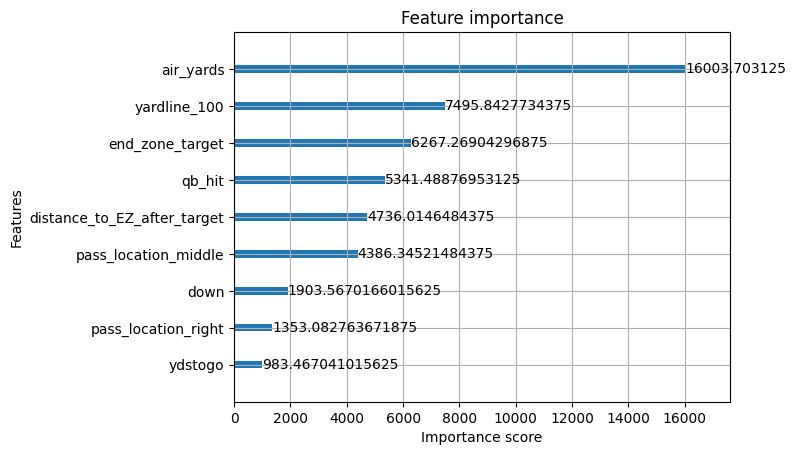

In [35]:
# Method 1: use model’s built-in feature_importances_
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': yardage_model.feature_importances_
}).sort_values(by='importance', ascending=False)

print(importance_df)

# Method 2: nice plot
plot_importance(yardage_model, importance_type='gain')
plt.show()


In [36]:
import pickle


with open('pass_yardage_model.pkl', 'wb') as file:
    pickle.dump(yardage_model, file)